In [1]:
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt

random_state = 42
torch.manual_seed(random_state)
np.random.seed(random_state)
random.seed(random_state)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

input_size = 5
output_size = 2
epsilon_start = 1.0
epsilon_end = 0.01
gamma = 0.99
num_episodes = 200

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# FFNN with 2 hidden layers
class FFNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim).to(device)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim).to(device)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim).to(device)
        self.fc_out = nn.Linear(hidden_dim, out_dim).to(device)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.fc_out(x)
        return x

# RNN with 2 RNN layers and 2 FC layers
class RNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, layer_num=1):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            in_dim, hidden_dim, num_layers=layer_num, batch_first=True, dropout=0.3 if layer_num > 1 else 0.0
        ).to(device)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim).to(device)
        self.fc2 = nn.Linear(hidden_dim, out_dim).to(device)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.relu(out[:, -1, :])  # Take output of the last time step
        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# LSTM with 2 layers for each component
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.bilstm = nn.LSTM(
            input_size, hidden_size, num_layers=num_layers, batch_first=True,
            dropout=0.3 if num_layers > 1 else 0.0, bidirectional=True
        )
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)
        self.residual_proj1 = nn.Linear(hidden_size * 2, hidden_size)
        self.residual_proj2 = nn.Linear(hidden_size, hidden_size)
        self.layer_norm1 = nn.LayerNorm(hidden_size)
        self.layer_norm2 = nn.LayerNorm(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        out, _ = self.bilstm(x)
        out = out[:, -1, :]  # Combine forward and backward outputs
        residual = self.residual_proj1(out)  # Match dimensions for residual connection
        out = self.fc1(out)
        out = self.layer_norm1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out += residual  # First residual connection
        residual = self.residual_proj2(out)  # Prepare for next layer
        out = self.fc2(out)
        out = self.layer_norm2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out += residual  # Second residual connection
        out = self.fc_out(out)
        return out

class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return zip(*random.sample(self.buffer, batch_size))

    def __len__(self):
        return len(self.buffer)

class IteratedPrisonersDilemma:
    def __init__(self, payoff_matrix=None):
        if payoff_matrix is None:
            payoff_matrix = [
                [3, 0],  # Cooperate vs Cooperate, Cooperate vs Defect
                [5, 1]   # Defect vs Cooperate, Defect vs Defect
            ]
        self.payoff_matrix = np.array(payoff_matrix)

    def step(self, action1, action2):
        reward1 = self.payoff_matrix[action1][action2]
        reward2 = self.payoff_matrix[action2][action1]
        return reward1, reward2

# Function to select an action based on the current state and epsilon-greedy policy
def select_action(state, epsilon, policy_net, output_size):
    if np.random.rand() < epsilon:
        return np.random.randint(output_size)
    else:
        with torch.no_grad():
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            q_values = policy_net(state_tensor)
            return q_values.argmax().item()

# Function to update Q-values using experience replay
def update_q_values(replay_buffer, batch_size, policy_net, target_net, optimizer, gamma):
    if len(replay_buffer) < batch_size:
        return
    states, actions, rewards, next_states = replay_buffer.sample(batch_size)
    states = torch.tensor(states, dtype=torch.float32).view(batch_size, 1, -1).to(device)
    actions = torch.tensor(actions, dtype=torch.long).to(device)
    rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.tensor(next_states, dtype=torch.float32).view(batch_size, 1, -1).to(device)

    q_values = policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
    next_q_values = target_net(next_states).max(1)[0].detach()
    expected_q_values = rewards + gamma * next_q_values

    loss = nn.functional.mse_loss(q_values, expected_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Function to train a DQN model using Optuna for hyperparameter optimization
def train_dqn(trial, model_class):
    hidden_size = trial.suggest_int('hidden_size', 64, 256)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    epsilon_decay = trial.suggest_uniform('epsilon_decay', 0.995, 0.999)
    target_update = trial.suggest_int('target_update', 5, 20)

    policy_net = model_class(input_size, hidden_size, output_size).to(device)
    target_net = model_class(input_size, hidden_size, output_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    replay_buffer = ReplayBuffer(capacity=10000)
    ipd_env = IteratedPrisonersDilemma()
    total_rewards = []

    for episode in range(num_episodes):
        state = [0, 0, 0, 0, 0]
        total_reward = 0
        for t in range(100):
            epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-episode / epsilon_decay)
            action = select_action(state, epsilon, policy_net, output_size)
            opponent_action = state[0]
            reward, opponent_reward = ipd_env.step(action, opponent_action)
            next_state = [action, opponent_action, reward, opponent_reward, t]
            replay_buffer.push(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            update_q_values(replay_buffer, batch_size, policy_net, target_net, optimizer, gamma)
            if t % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())
        total_rewards.append(total_reward)

    avg_reward = np.mean(total_rewards)
    return avg_reward

# Function to optimize a model using Optuna
def optimize_model(model_class):
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: train_dqn(trial, model_class), n_trials=50)
    print(f"Best trial: {study.best_trial.params}")
    return study.best_trial.params

# Function to test the model against a fixed strategy
def play_ipd(policy_net, num_episodes, strategy, epsilon=0.0):
    ipd_env = IteratedPrisonersDilemma()
    total_rewards = []
    opponent_rewards = []
    mutual_cooperations = []
    agent_cooperations = []

    for episode in range(num_episodes):
        state = [0, 0, 0, 0, 0]
        total_reward = 0
        opponent_total_reward = 0
        opponent_last_action = 0
        grim_trigger_active = False
        episode_mutual_cooperations = 0
        episode_agent_cooperations = 0

        for t in range(100):
            with torch.no_grad():
                if np.random.rand() < epsilon:
                    action = np.random.randint(output_size)
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
                    q_values = policy_net(state_tensor)
                    action = q_values.argmax().item()

            if strategy == "random":
                opponent_action = np.random.randint(2)
            elif strategy == "tft":
                opponent_action = opponent_last_action
            elif strategy == "grim_trigger":
                if grim_trigger_active:
                    opponent_action = 1
                else:
                    opponent_action = 0
                    if action == 1:
                        grim_trigger_active = True
            elif strategy == "always_cooperate":
                opponent_action = 0
            elif strategy == "always_defect":
                opponent_action = 1

            reward, opponent_reward = ipd_env.step(action, opponent_action)
            total_reward += reward
            opponent_total_reward += opponent_reward

            # Count cooperation and mutual cooperation
            if action == 0:
                episode_agent_cooperations += 1
            if action == 0 and opponent_action == 0:
                episode_mutual_cooperations += 1

            next_state = [action, opponent_action, reward, 0, t]
            state = next_state
            opponent_last_action = action

        total_rewards.append(total_reward)
        opponent_rewards.append(opponent_total_reward)
        mutual_cooperations.append(episode_mutual_cooperations)
        agent_cooperations.append(episode_agent_cooperations)

    avg_reward = np.mean(total_rewards)
    return total_rewards, opponent_rewards, mutual_cooperations, agent_cooperations

Using device: cuda


In [2]:
def test_against_strategies(policy_net, num_episodes):
    strategies = ["random", "tft", "always_cooperate", "always_defect", "grim_trigger"]
    results = {}

    for strategy in strategies:
        print(f"Testing against {strategy} strategy")
        (
            agent_rewards,
            opponent_rewards,
            mutual_cooperations,
            agent_cooperations,
        ) = play_ipd(policy_net, num_episodes, strategy, epsilon=0.1)
        
        results[strategy] = {
            "agent_rewards": agent_rewards,
            "opponent_rewards": opponent_rewards,
            "mutual_cooperations": mutual_cooperations,
            "agent_cooperations": agent_cooperations,
        }

        # Plot total rewards per episode
        plt.figure(figsize=(12, 6))
        plt.plot(agent_rewards, label="Agent Rewards per Episode")
        plt.plot(opponent_rewards, label="Opponent Rewards per Episode")
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.legend()
        plt.title(f"Total Rewards per Episode against {strategy.upper()}")
        plt.show()

        # Plot mutual cooperations vs. agent rewards
        plt.figure(figsize=(12, 6))
        plt.plot(mutual_cooperations, label="Mutual Cooperations per Episode")
        plt.plot(agent_rewards, label="Agent Rewards per Episode")
        plt.xlabel("Episode")
        plt.ylabel("Count/Reward")
        plt.legend()
        plt.title(f"Mutual Cooperations vs Agent Rewards per Episode against {strategy.upper()}")
        plt.show()

    return results

In [3]:
print("Optimizing FFNN...")
# ffnn_params = optimize_model(FFNN)
ffnn_params = {'hidden_size': 76, 'learning_rate': 0.001992730315194821, 'batch_size': 128, 'epsilon_decay': 0.9981415166545647, 'target_update': 14}

Optimizing FFNN...


In [4]:
print("Optimizing RNN...")
# rnn_params = optimize_model(RNN)
rnn_params = {'hidden_size': 76, 'learning_rate': 0.001992730315194821, 'batch_size': 128, 'epsilon_decay': 0.9981415166545647, 'target_update': 14}

Optimizing RNN...


In [5]:
print("Optimizing LSTM...")
lstm_params = {'hidden_size': 76, 'learning_rate': 0.001992730315194821, 'batch_size': 128, 'epsilon_decay': 0.9981415166545647, 'target_update': 14}
# lstm_params = optimize_model(LSTM)

Optimizing LSTM...


In [6]:
def train_final_model(model_class, params):
    hidden_size = params["hidden_size"]
    learning_rate = params["learning_rate"]
    batch_size = params["batch_size"]
    epsilon_decay = params["epsilon_decay"]
    target_update = params["target_update"]
    output_size = 2

    policy_net = model_class(input_size, hidden_size, output_size).to(device)
    target_net = model_class(input_size, hidden_size, output_size).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    replay_buffer = ReplayBuffer(capacity=10000)
    ipd_env = IteratedPrisonersDilemma()

    for episode in range(num_episodes):
        state = [0, 0, 0, 0, 0]
        total_reward = 0
        for t in range(100):
            epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-episode / epsilon_decay)
            action = select_action(state, epsilon, policy_net, output_size)
            opponent_action = state[0]
            reward, opponent_reward = ipd_env.step(action, opponent_action)
            next_state = [action, opponent_action, reward, opponent_reward, t]
            replay_buffer.push(state, action, reward, next_state)
            state = next_state
            total_reward += reward
            update_q_values(replay_buffer, batch_size, policy_net, target_net, optimizer, gamma)
            if t % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())
        print(f"Episode {episode + 1}, Total Reward: {total_reward}")

    results = test_against_strategies(policy_net, num_episodes=100)
    return results

Episode 1, Total Reward: 212
Episode 2, Total Reward: 192
Episode 3, Total Reward: 287
Episode 4, Total Reward: 285
Episode 5, Total Reward: 281
Episode 6, Total Reward: 279
Episode 7, Total Reward: 296
Episode 8, Total Reward: 285
Episode 9, Total Reward: 276
Episode 10, Total Reward: 289
Episode 11, Total Reward: 281
Episode 12, Total Reward: 280
Episode 13, Total Reward: 257
Episode 14, Total Reward: 264
Episode 15, Total Reward: 273
Episode 16, Total Reward: 245
Episode 17, Total Reward: 227
Episode 18, Total Reward: 217
Episode 19, Total Reward: 277
Episode 20, Total Reward: 260
Episode 21, Total Reward: 233
Episode 22, Total Reward: 285
Episode 23, Total Reward: 268
Episode 24, Total Reward: 292
Episode 25, Total Reward: 288
Episode 26, Total Reward: 296
Episode 27, Total Reward: 289
Episode 28, Total Reward: 285
Episode 29, Total Reward: 285
Episode 30, Total Reward: 285
Episode 31, Total Reward: 287
Episode 32, Total Reward: 283
Episode 33, Total Reward: 285
Episode 34, Total R

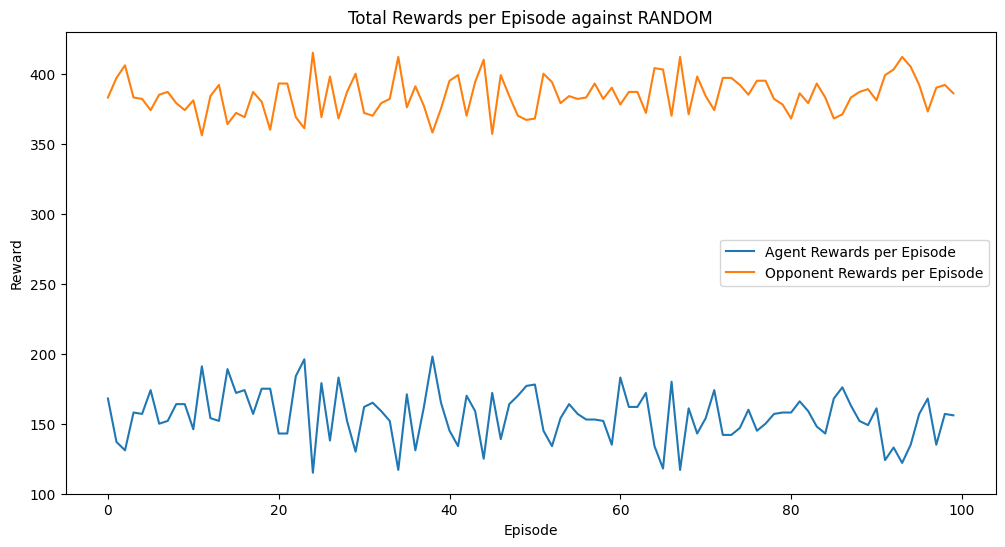

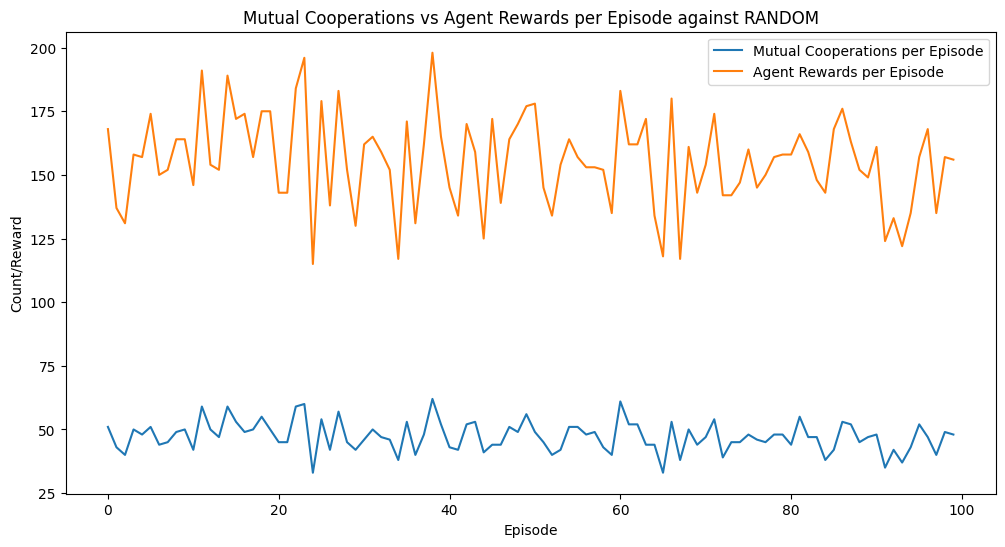

Testing against tft strategy


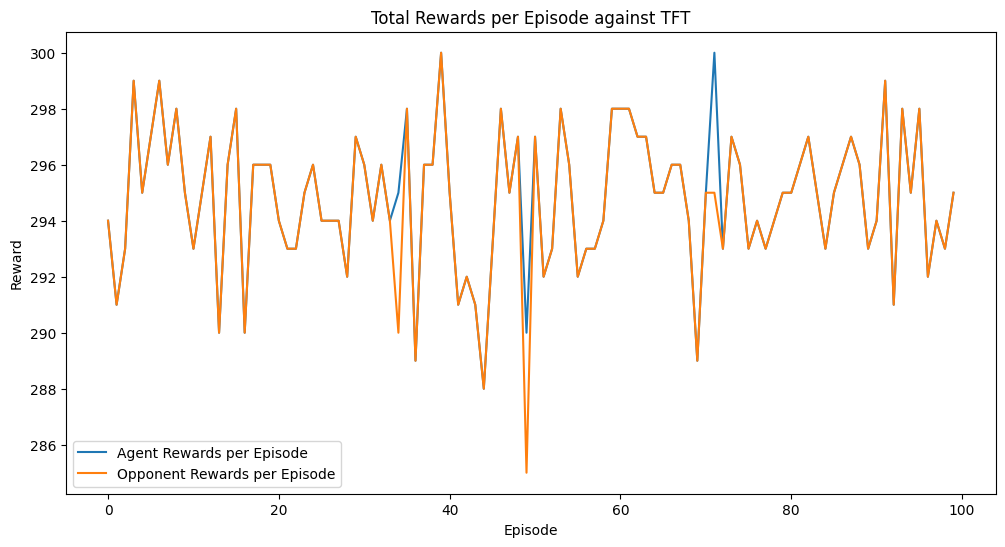

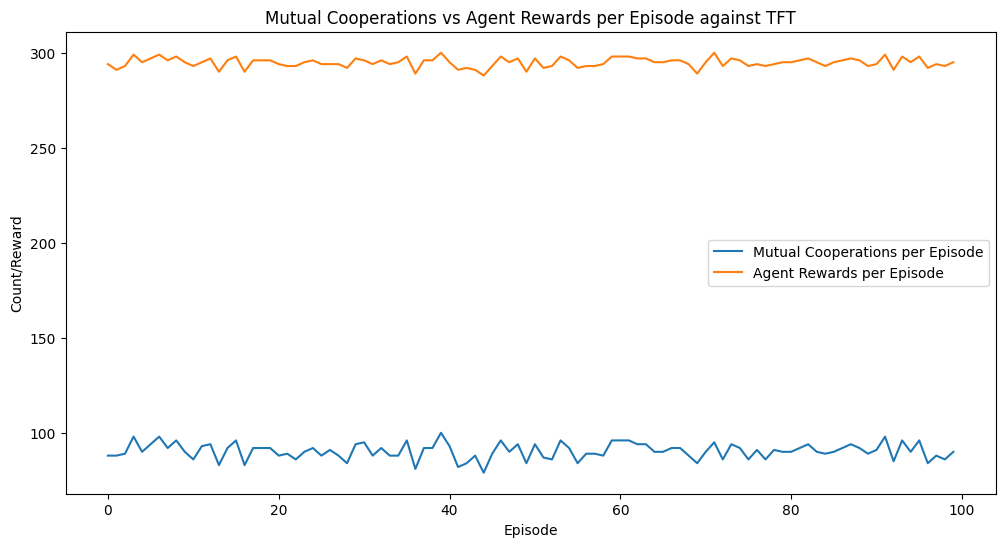

Testing against always_cooperate strategy


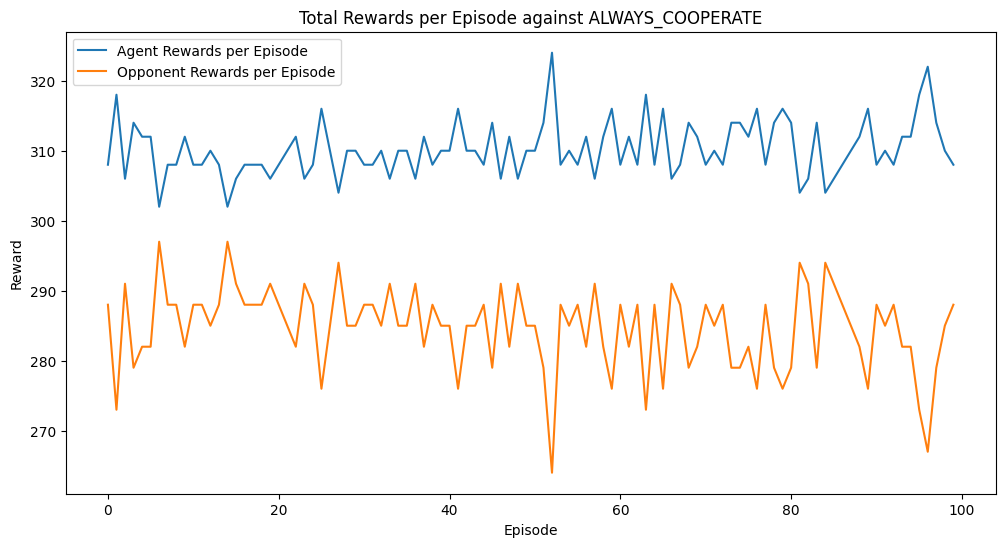

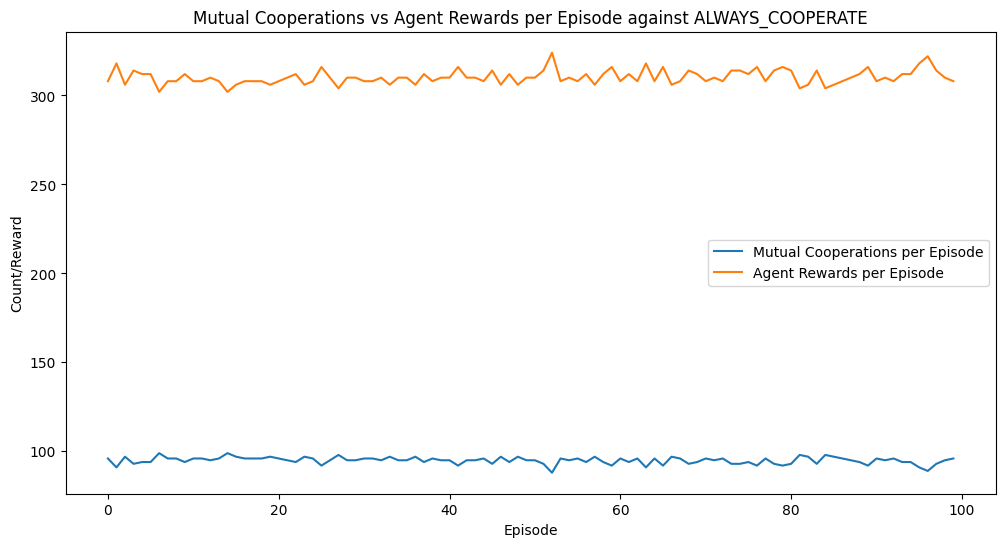

Testing against always_defect strategy


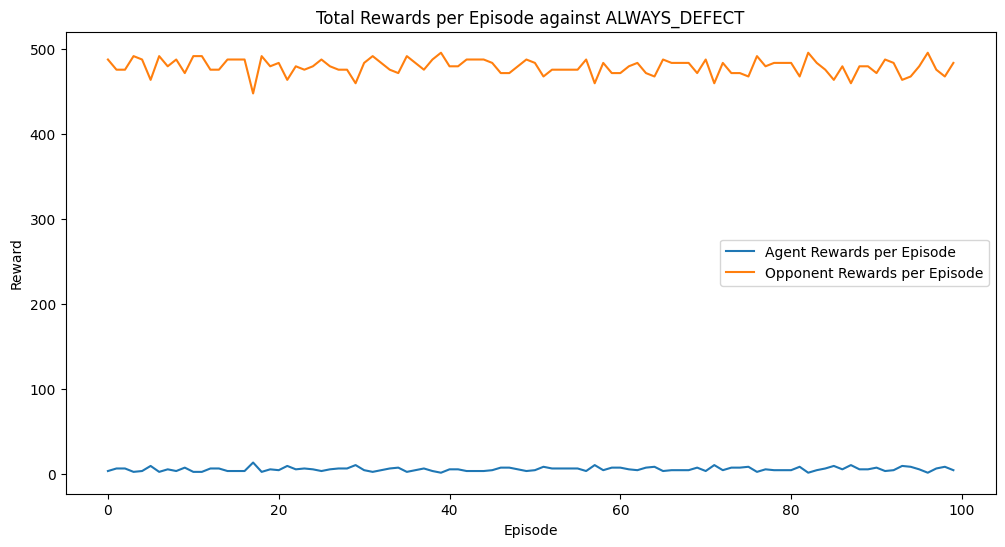

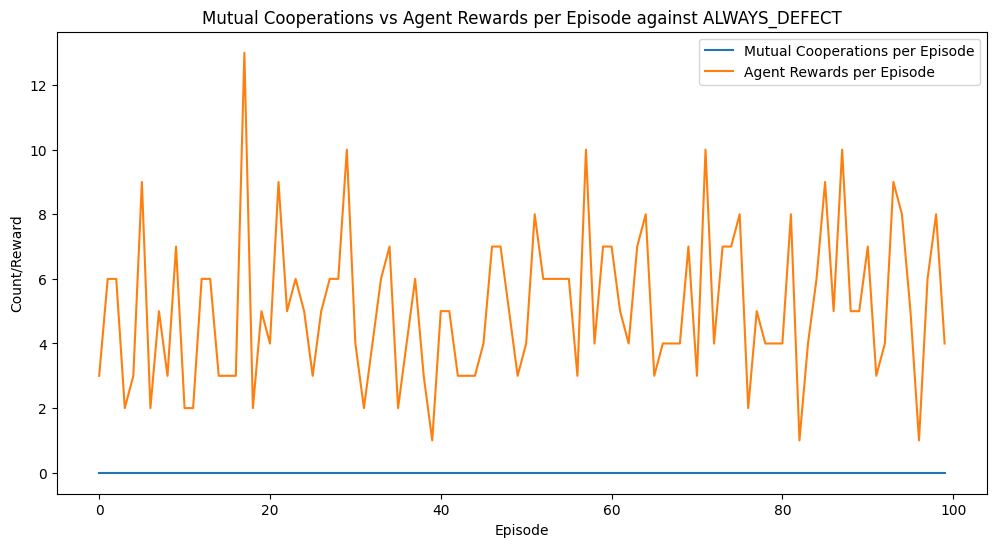

Testing against grim_trigger strategy


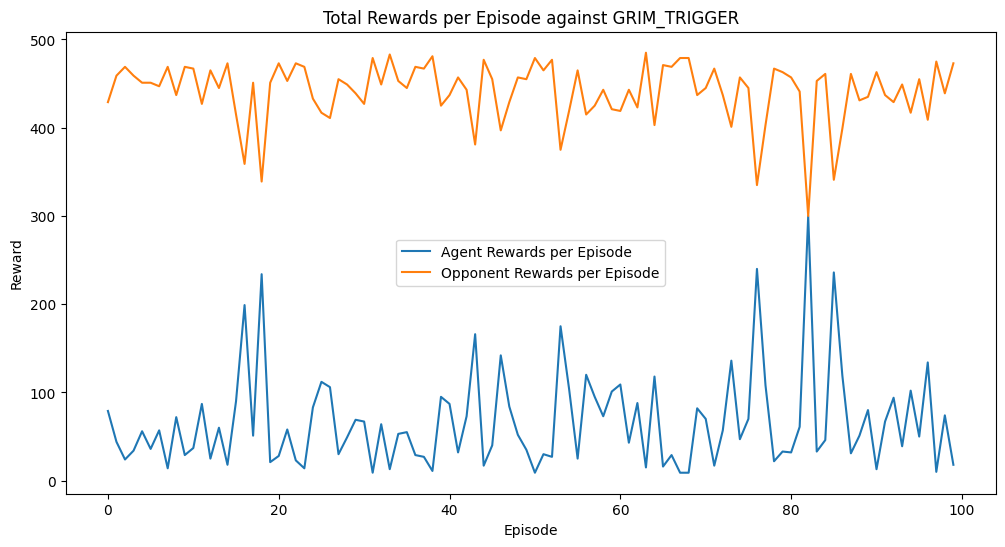

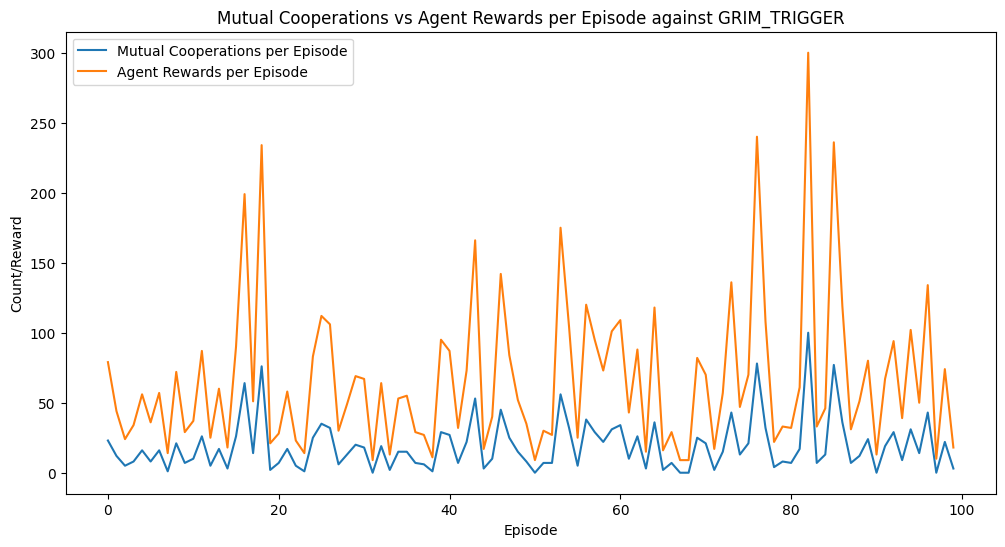

In [7]:
ffnn_rewards = train_final_model(FFNN, ffnn_params)

In [8]:
for strategy, metrics in ffnn_rewards.items():
    avg_agent_rewards = np.mean(metrics["agent_rewards"])
    avg_opponent_rewards = np.mean(metrics["opponent_rewards"])
    avg_mutual_cooperations = np.mean(metrics["mutual_cooperations"])
    avg_agent_cooperations = np.mean(metrics["agent_cooperations"])

    print(f"Strategy: {strategy}")
    print(f"  Average Agent Rewards: {avg_agent_rewards:.2f}")
    print(f"  Average Opponent Rewards: {avg_opponent_rewards:.2f}")
    print(f"  Average Mutual Cooperations: {avg_mutual_cooperations:.2f}")
    print(f"  Average Agent Cooperations: {avg_agent_cooperations:.2f}")
    print()

Strategy: random
  Average Agent Rewards: 155.56
  Average Opponent Rewards: 384.41
  Average Mutual Cooperations: 47.29
  Average Agent Cooperations: 95.31

Strategy: tft
  Average Agent Rewards: 294.83
  Average Opponent Rewards: 294.68
  Average Mutual Cooperations: 90.41
  Average Agent Cooperations: 95.04

Strategy: always_cooperate
  Average Agent Rewards: 310.22
  Average Opponent Rewards: 284.67
  Average Mutual Cooperations: 94.89
  Average Agent Cooperations: 94.89

Strategy: always_defect
  Average Agent Rewards: 5.13
  Average Opponent Rewards: 479.48
  Average Mutual Cooperations: 0.00
  Average Agent Cooperations: 94.87

Strategy: grim_trigger
  Average Agent Rewards: 66.57
  Average Opponent Rewards: 441.07
  Average Mutual Cooperations: 19.25
  Average Agent Cooperations: 95.14



Episode 1, Total Reward: 227
Episode 2, Total Reward: 173
Episode 3, Total Reward: 274
Episode 4, Total Reward: 271
Episode 5, Total Reward: 291
Episode 6, Total Reward: 291
Episode 7, Total Reward: 299
Episode 8, Total Reward: 275
Episode 9, Total Reward: 296
Episode 10, Total Reward: 294
Episode 11, Total Reward: 277
Episode 12, Total Reward: 262
Episode 13, Total Reward: 289
Episode 14, Total Reward: 294
Episode 15, Total Reward: 293
Episode 16, Total Reward: 290
Episode 17, Total Reward: 289
Episode 18, Total Reward: 287
Episode 19, Total Reward: 272
Episode 20, Total Reward: 295
Episode 21, Total Reward: 282
Episode 22, Total Reward: 299
Episode 23, Total Reward: 294
Episode 24, Total Reward: 246
Episode 25, Total Reward: 261
Episode 26, Total Reward: 288
Episode 27, Total Reward: 272
Episode 28, Total Reward: 276
Episode 29, Total Reward: 274
Episode 30, Total Reward: 279
Episode 31, Total Reward: 284
Episode 32, Total Reward: 292
Episode 33, Total Reward: 300
Episode 34, Total R

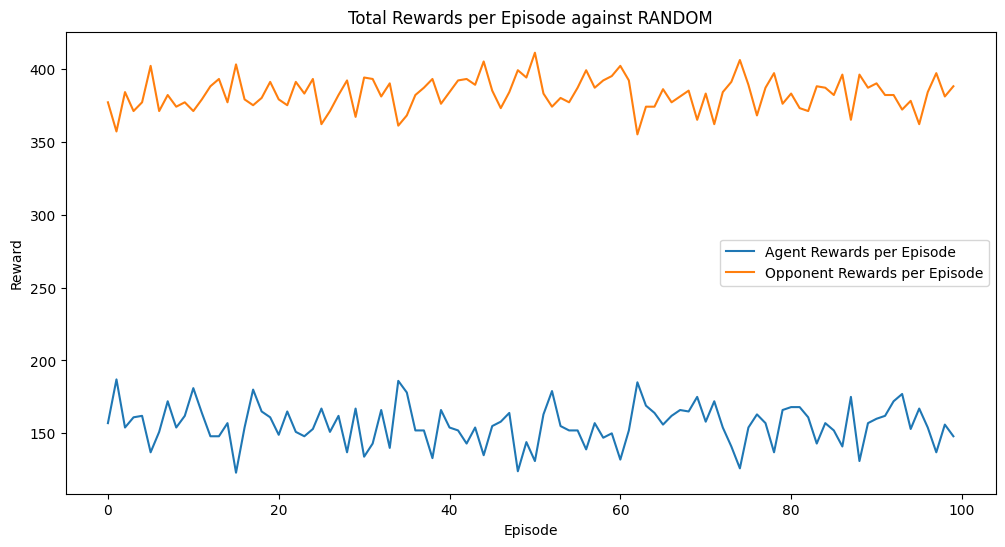

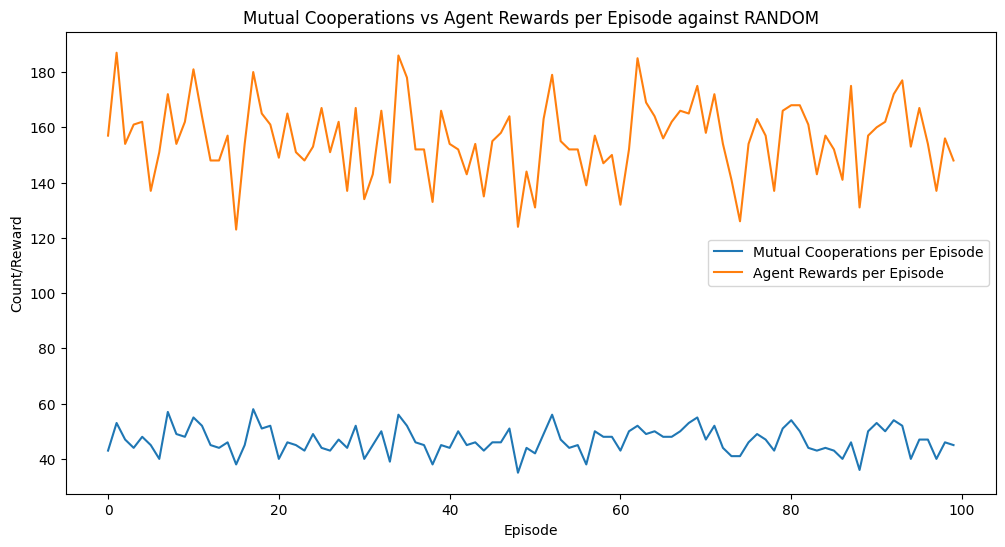

Testing against tft strategy


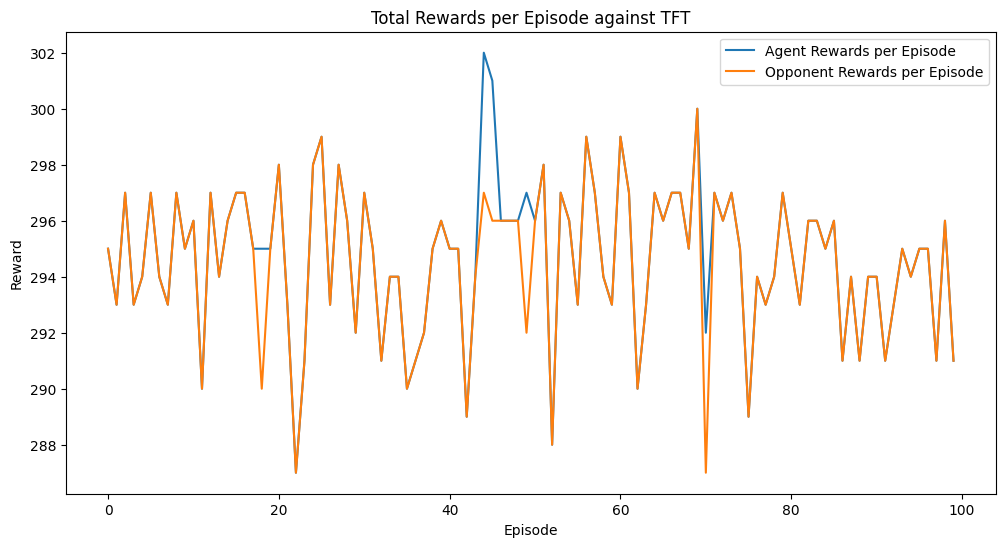

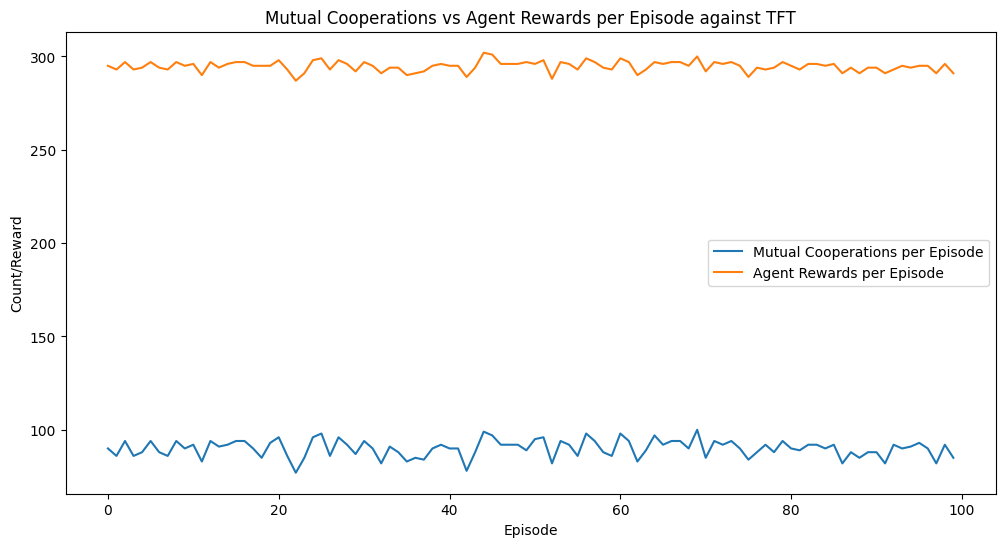

Testing against always_cooperate strategy


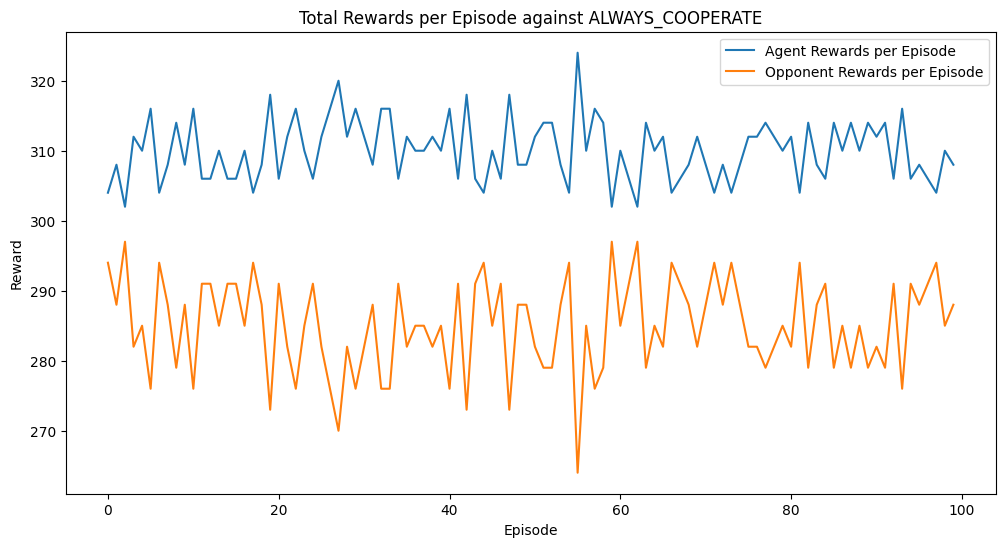

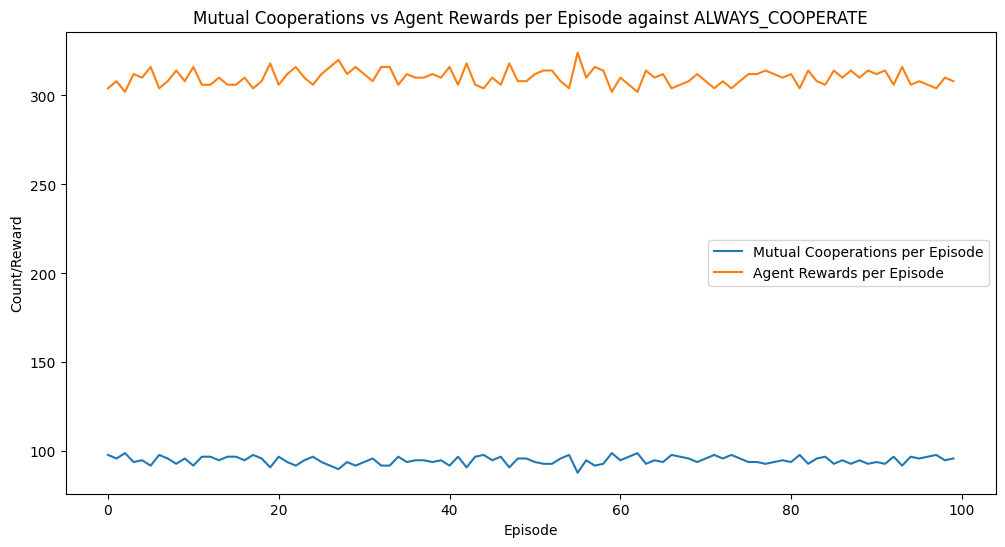

Testing against always_defect strategy


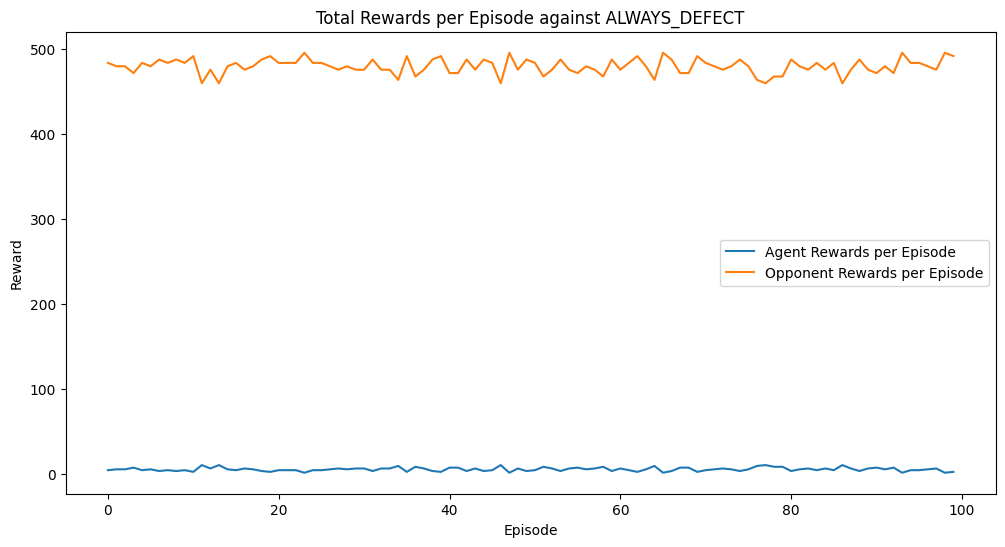

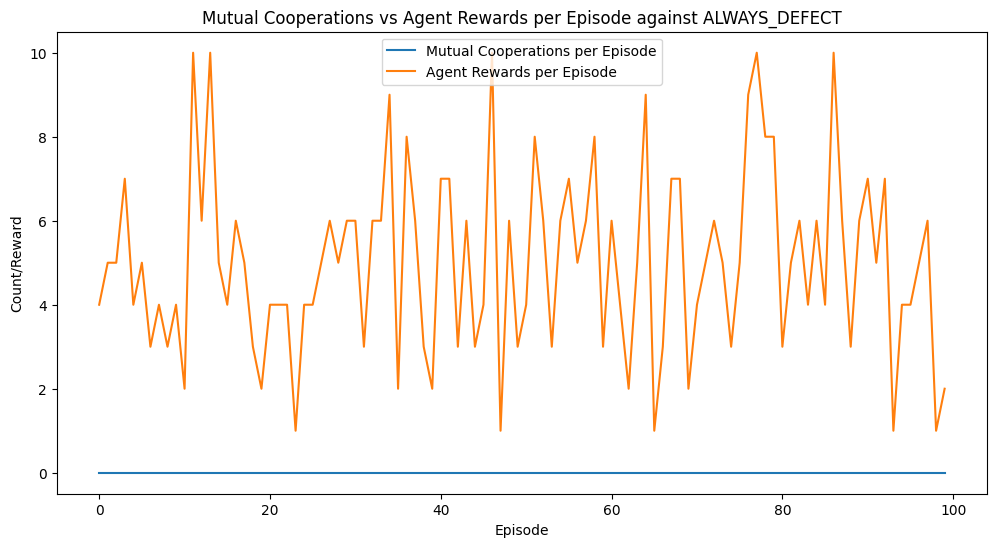

Testing against grim_trigger strategy


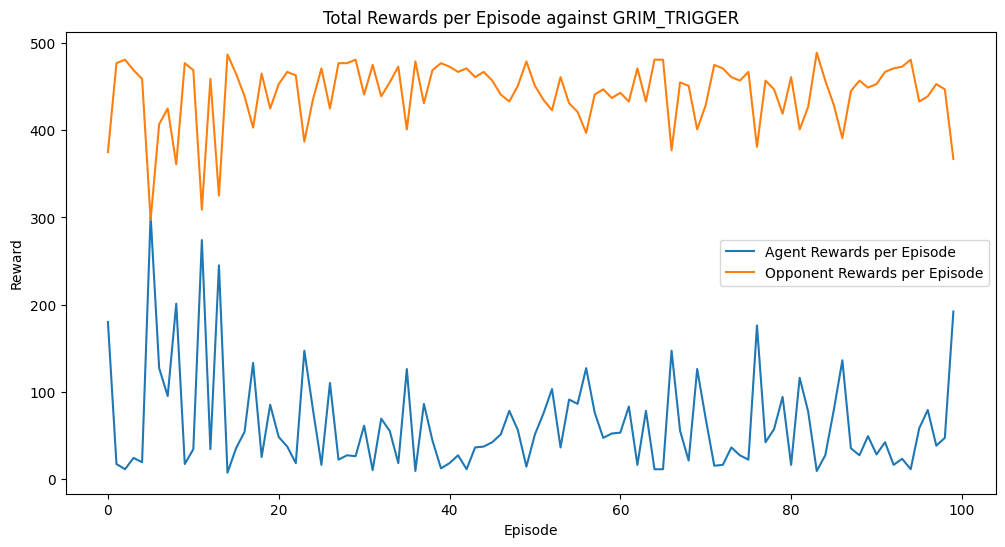

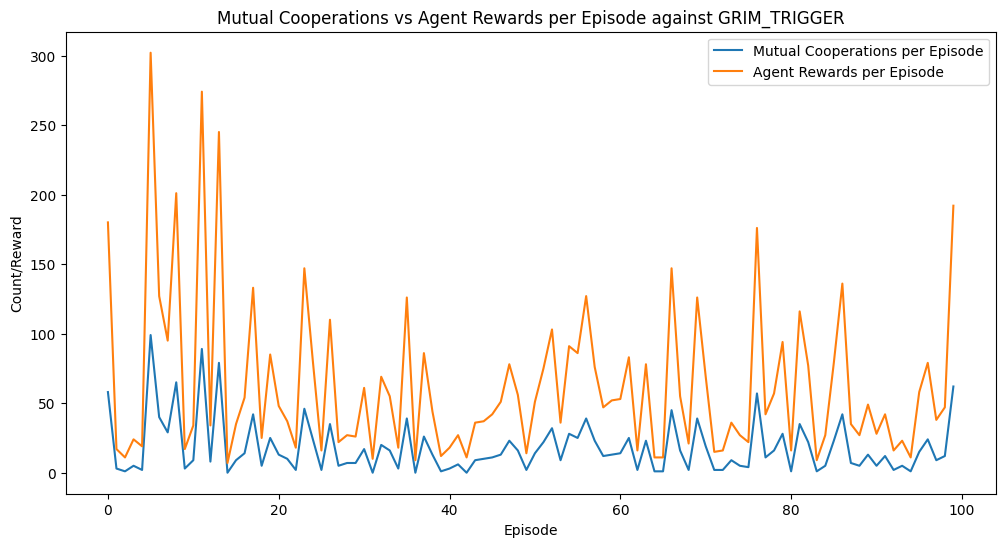

In [9]:
rnn_rewards = train_final_model(RNN, rnn_params)

In [10]:
for strategy, metrics in rnn_rewards.items():
    avg_agent_rewards = np.mean(metrics["agent_rewards"])
    avg_opponent_rewards = np.mean(metrics["opponent_rewards"])
    avg_mutual_cooperations = np.mean(metrics["mutual_cooperations"])
    avg_agent_cooperations = np.mean(metrics["agent_cooperations"])

    print(f"Strategy: {strategy}")
    print(f"  Average Agent Rewards: {avg_agent_rewards:.2f}")
    print(f"  Average Opponent Rewards: {avg_opponent_rewards:.2f}")
    print(f"  Average Mutual Cooperations: {avg_mutual_cooperations:.2f}")
    print(f"  Average Agent Cooperations: {avg_agent_cooperations:.2f}")
    print()

Strategy: random
  Average Agent Rewards: 155.79
  Average Opponent Rewards: 382.89
  Average Mutual Cooperations: 46.69
  Average Agent Cooperations: 94.72

Strategy: tft
  Average Agent Rewards: 294.73
  Average Opponent Rewards: 294.48
  Average Mutual Cooperations: 90.05
  Average Agent Cooperations: 94.86

Strategy: always_cooperate
  Average Agent Rewards: 310.04
  Average Opponent Rewards: 284.94
  Average Mutual Cooperations: 94.98
  Average Agent Cooperations: 94.98

Strategy: always_defect
  Average Agent Rewards: 5.01
  Average Opponent Rewards: 479.96
  Average Mutual Cooperations: 0.00
  Average Agent Cooperations: 94.99

Strategy: grim_trigger
  Average Agent Rewards: 63.14
  Average Opponent Rewards: 442.74
  Average Mutual Cooperations: 18.03
  Average Agent Cooperations: 94.95



Episode 1, Total Reward: 219
Episode 2, Total Reward: 198
Episode 3, Total Reward: 280
Episode 4, Total Reward: 296
Episode 5, Total Reward: 297
Episode 6, Total Reward: 295
Episode 7, Total Reward: 289
Episode 8, Total Reward: 289
Episode 9, Total Reward: 288
Episode 10, Total Reward: 293
Episode 11, Total Reward: 298
Episode 12, Total Reward: 290
Episode 13, Total Reward: 296
Episode 14, Total Reward: 296
Episode 15, Total Reward: 297
Episode 16, Total Reward: 299
Episode 17, Total Reward: 297
Episode 18, Total Reward: 298
Episode 19, Total Reward: 299
Episode 20, Total Reward: 299
Episode 21, Total Reward: 299
Episode 22, Total Reward: 300
Episode 23, Total Reward: 299
Episode 24, Total Reward: 300
Episode 25, Total Reward: 300
Episode 26, Total Reward: 299
Episode 27, Total Reward: 299
Episode 28, Total Reward: 300
Episode 29, Total Reward: 296
Episode 30, Total Reward: 299
Episode 31, Total Reward: 299
Episode 32, Total Reward: 300
Episode 33, Total Reward: 300
Episode 34, Total R

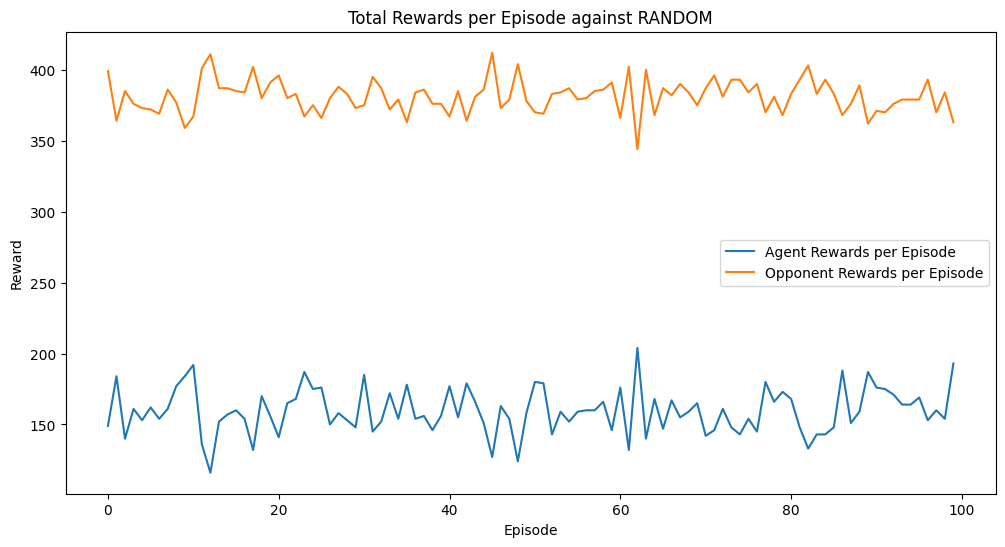

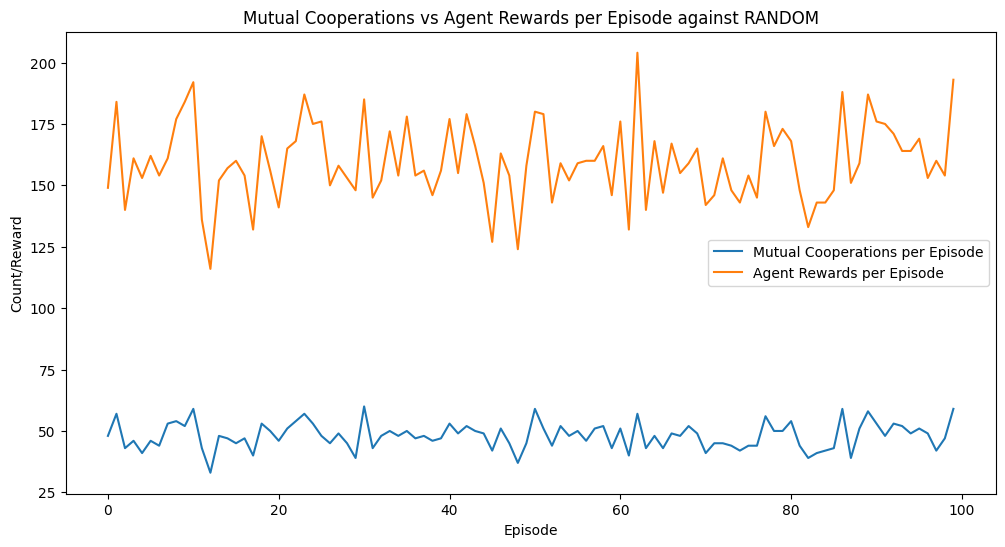

Testing against tft strategy


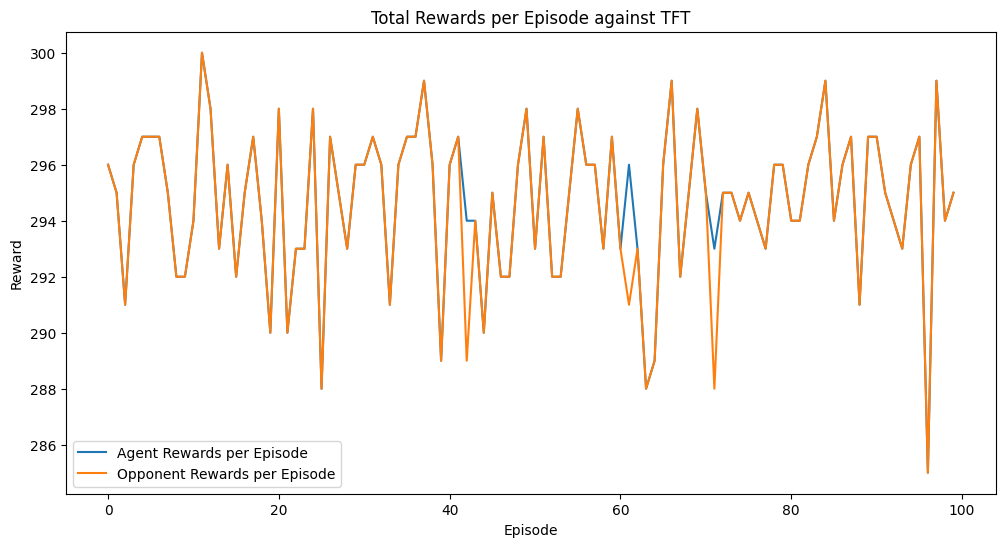

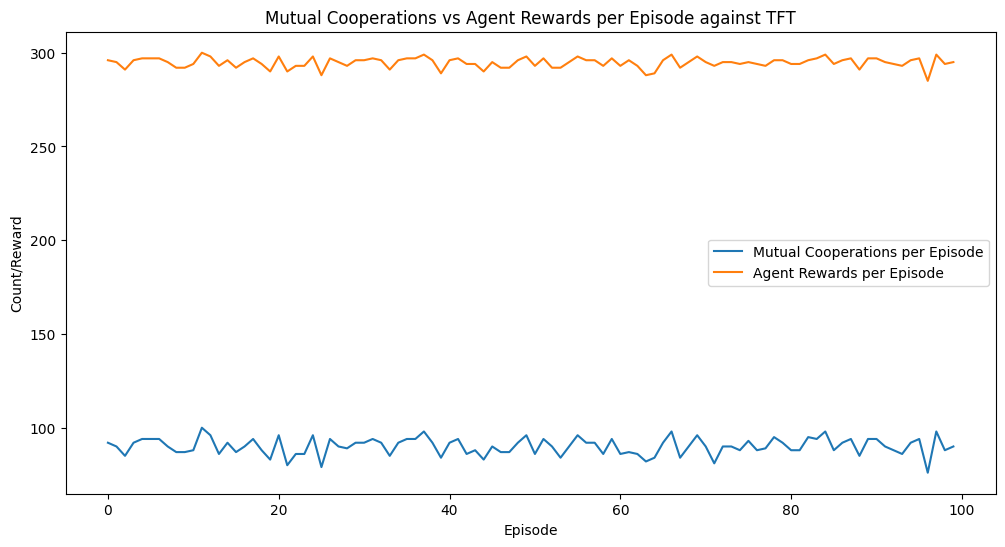

Testing against always_cooperate strategy


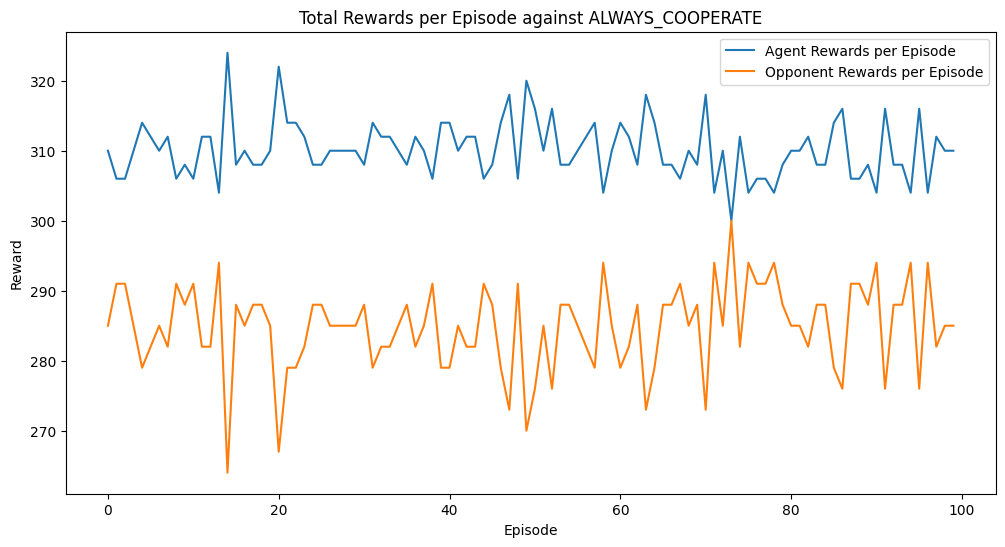

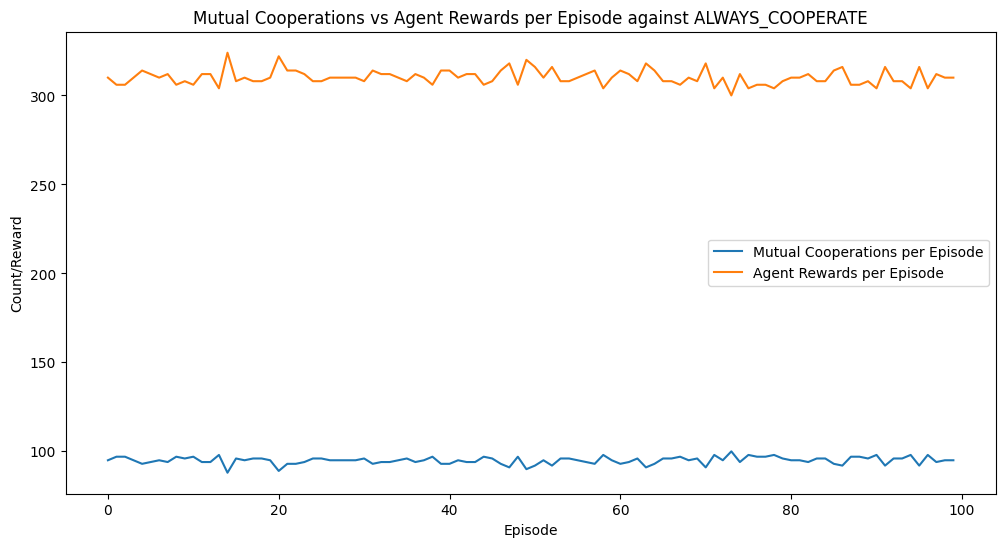

Testing against always_defect strategy


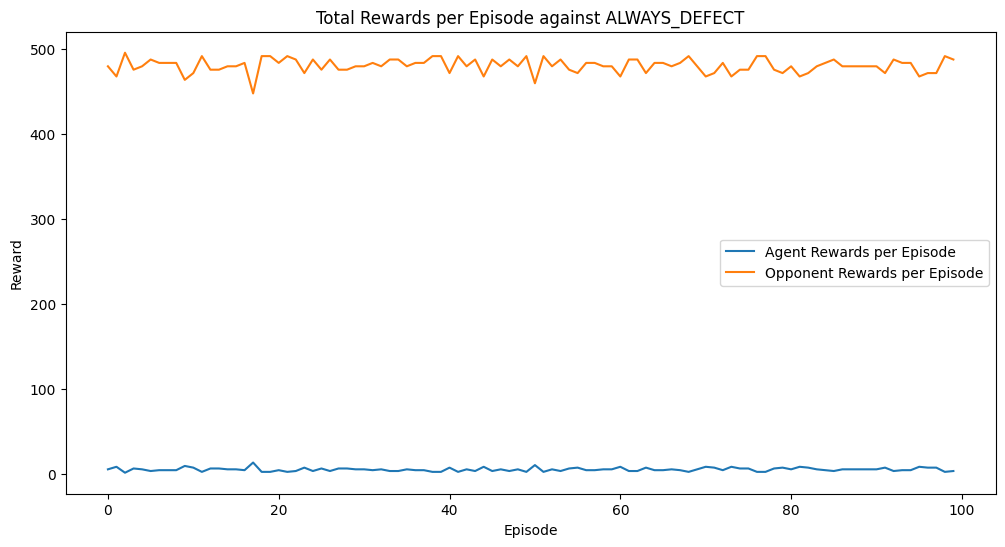

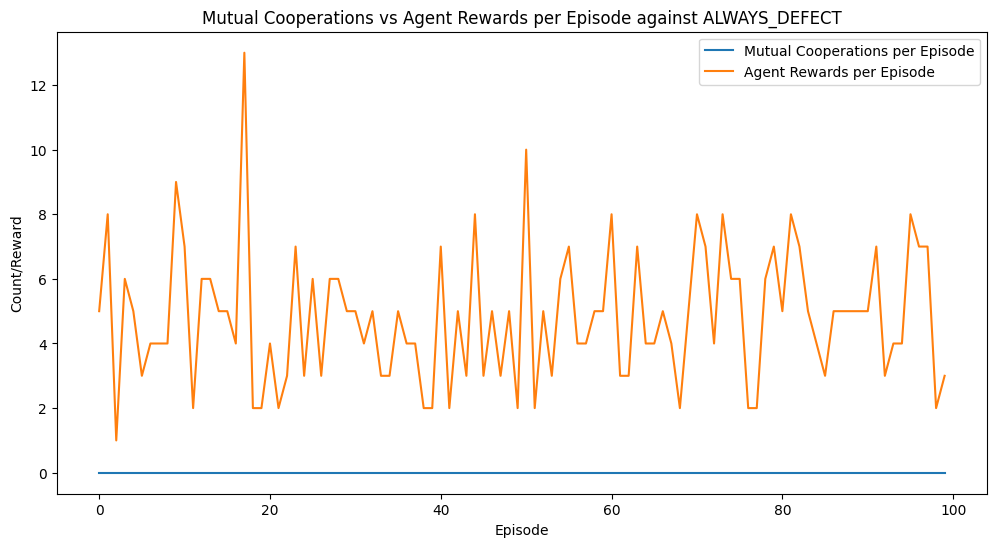

Testing against grim_trigger strategy


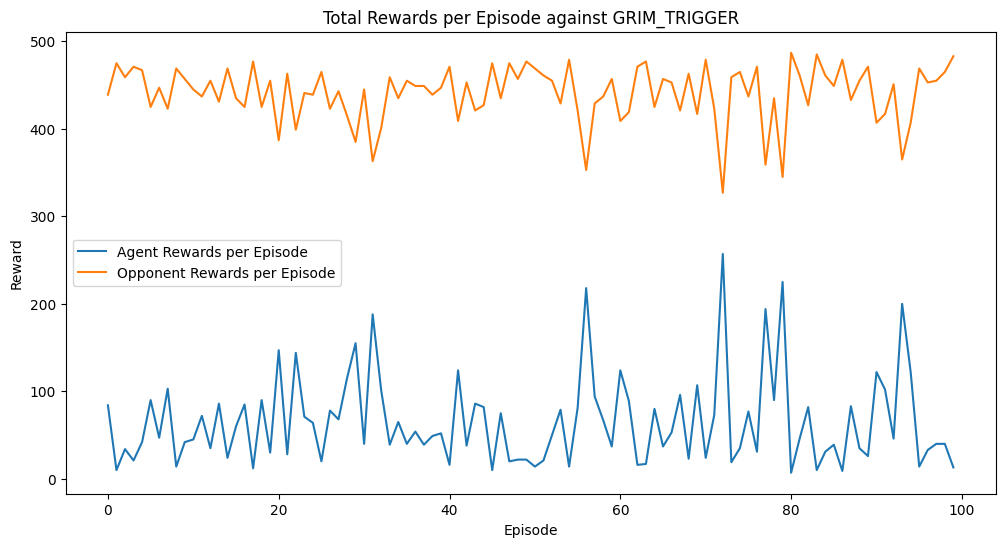

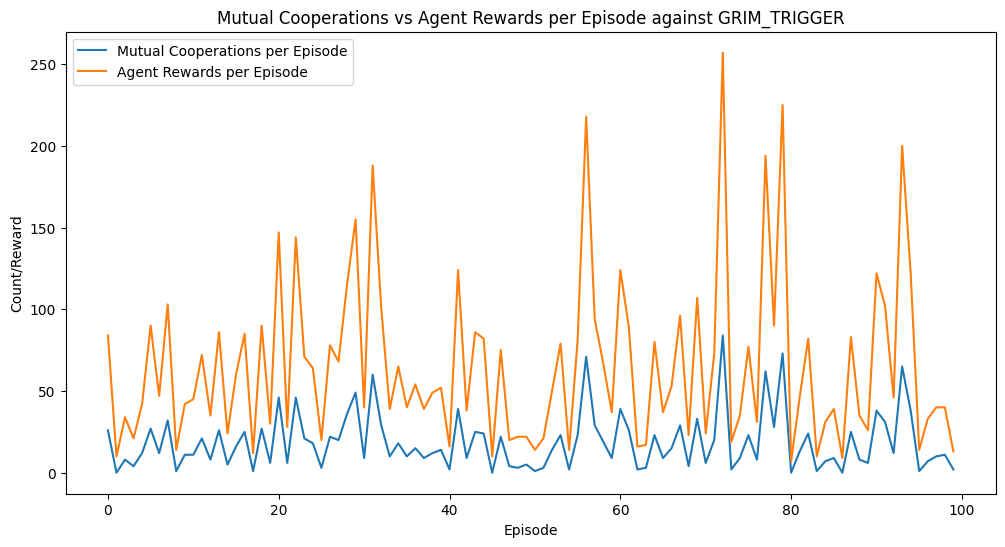

In [11]:
lstm_rewards = train_final_model(LSTM, lstm_params)

In [12]:
for strategy, metrics in lstm_rewards.items():
    avg_agent_rewards = np.mean(metrics["agent_rewards"])
    avg_opponent_rewards = np.mean(metrics["opponent_rewards"])
    avg_mutual_cooperations = np.mean(metrics["mutual_cooperations"])
    avg_agent_cooperations = np.mean(metrics["agent_cooperations"])

    print(f"Strategy: {strategy}")
    print(f"  Average Agent Rewards: {avg_agent_rewards:.2f}")
    print(f"  Average Opponent Rewards: {avg_opponent_rewards:.2f}")
    print(f"  Average Mutual Cooperations: {avg_mutual_cooperations:.2f}")
    print(f"  Average Agent Cooperations: {avg_agent_cooperations:.2f}")
    print()

Strategy: random
  Average Agent Rewards: 159.45
  Average Opponent Rewards: 381.20
  Average Mutual Cooperations: 48.06
  Average Agent Cooperations: 94.97

Strategy: tft
  Average Agent Rewards: 294.70
  Average Opponent Rewards: 294.55
  Average Mutual Cooperations: 90.06
  Average Agent Cooperations: 94.88

Strategy: always_cooperate
  Average Agent Rewards: 310.16
  Average Opponent Rewards: 284.76
  Average Mutual Cooperations: 94.92
  Average Agent Cooperations: 94.92

Strategy: always_defect
  Average Agent Rewards: 4.80
  Average Opponent Rewards: 480.80
  Average Mutual Cooperations: 0.00
  Average Agent Cooperations: 95.20

Strategy: grim_trigger
  Average Agent Rewards: 65.20
  Average Opponent Rewards: 440.70
  Average Mutual Cooperations: 18.65
  Average Agent Cooperations: 94.75



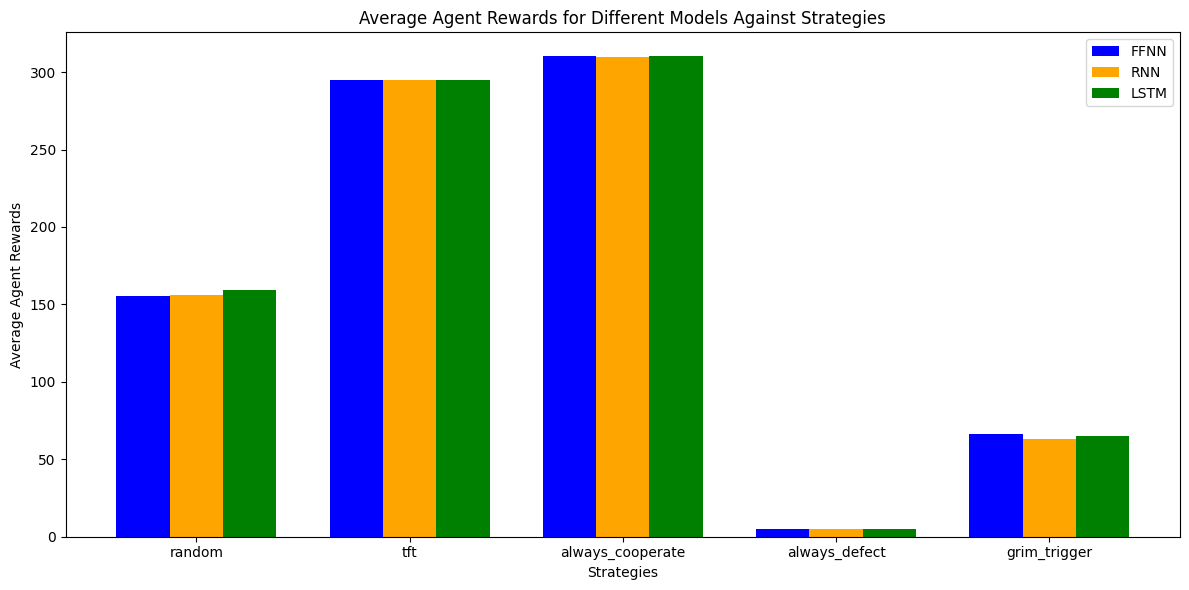

In [13]:
import matplotlib.pyplot as plt
import numpy as np

strategies = list(ffnn_rewards.keys()) 
models = ["FFNN", "RNN", "LSTM"]

avg_rewards = {
    "FFNN": [np.mean(ffnn_rewards[strategy]["agent_rewards"]) for strategy in strategies],
    "RNN": [np.mean(rnn_rewards[strategy]["agent_rewards"]) for strategy in strategies],
    "LSTM": [np.mean(lstm_rewards[strategy]["agent_rewards"]) for strategy in strategies],
}

x = np.arange(len(strategies)) 
width = 0.25 

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width, avg_rewards["FFNN"], width, label="FFNN", color="blue")
ax.bar(x, avg_rewards["RNN"], width, label="RNN", color="orange")
ax.bar(x + width, avg_rewards["LSTM"], width, label="LSTM", color="green")

ax.set_xlabel("Strategies")
ax.set_ylabel("Average Agent Rewards")
ax.set_title("Average Agent Rewards for Different Models Against Strategies")
ax.set_xticks(x)
ax.set_xticklabels(strategies)
ax.legend()

plt.tight_layout()
plt.show()


Evaluating for Payoff Matrix 1: [[3, 0], [5, 1]]
FFNN: Avg Reward = 155.56
RNN: Avg Reward = 155.79
LSTM: Avg Reward = 159.45

Evaluating for Payoff Matrix 2: [[4, -10], [10, 0]]
FFNN: Avg Reward = 294.83
RNN: Avg Reward = 294.73
LSTM: Avg Reward = 294.70

Evaluating for Payoff Matrix 3: [[10, 2], [12, 5]]
FFNN: Avg Reward = 310.22
RNN: Avg Reward = 310.04
LSTM: Avg Reward = 310.16


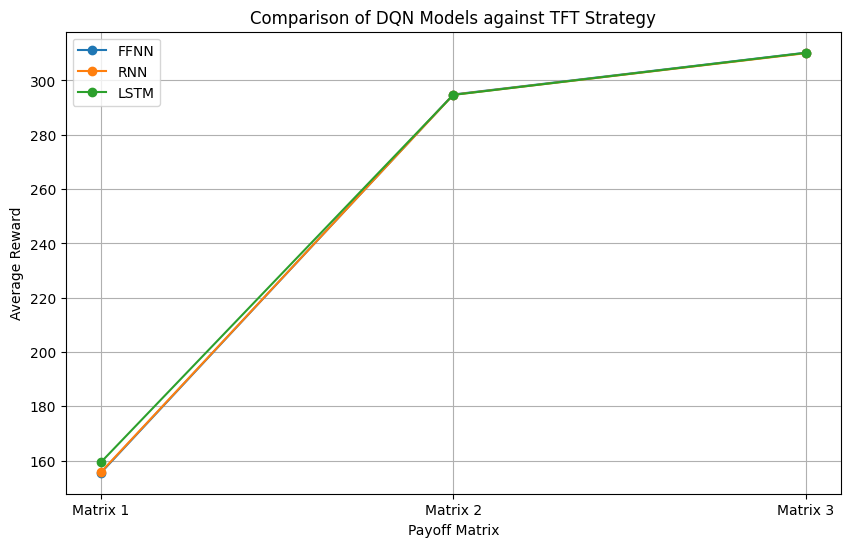

In [14]:
def compare_models(avg_rewards, payoff_matrices):
    results = {model: [] for model in avg_rewards}
    
    for i, payoff_matrix in enumerate(payoff_matrices):
        print(f"\nEvaluating for Payoff Matrix {i + 1}: {payoff_matrix}")

        for model_name, rewards in avg_rewards.items():
            avg_reward = rewards[i]
            results[model_name].append(avg_reward)
            print(f"{model_name}: Avg Reward = {avg_reward:.2f}")

    return results

# Function to visualize comparison results
def plot_results(results, payoff_matrices):
    plt.figure(figsize=(10, 6))
    
    for model_name, rewards in results.items():
        plt.plot(range(1, len(payoff_matrices) + 1), rewards, marker='o', label=model_name)

    plt.title('Comparison of DQN Models against TFT Strategy')
    plt.xlabel('Payoff Matrix')
    plt.ylabel('Average Reward')
    plt.xticks(range(1, len(payoff_matrices) + 1), [f'Matrix {i+1}' for i in range(len(payoff_matrices))])
    plt.legend()
    plt.grid(True)
    plt.show()

# Define the different payoff matrices to test
payoff_matrices = [
    [[3, 0], [5, 1]],  # Default Prisoner's Dilemma matrix
    [[4, -10], [10, 0]],  # Modified matrix 1
    [[10, 2], [12, 5]]   # Modified matrix 2
]

# Provided reward data
avg_rewards = {
    "FFNN": [np.mean(ffnn_rewards[strategy]["agent_rewards"]) for strategy in strategies],
    "RNN": [np.mean(rnn_rewards[strategy]["agent_rewards"]) for strategy in strategies],
    "LSTM": [np.mean(lstm_rewards[strategy]["agent_rewards"]) for strategy in strategies],
}

# Run the comparison and visualization
results = compare_models(avg_rewards, payoff_matrices)
plot_results(results, payoff_matrices)
